In [1]:
pip install chembl_webresource_client

Note: you may need to restart the kernel to use updated packages.


In [2]:
!sudo apt-get install python3-rdkit

Sudo is disabled on this machine. To enable it, go to the ]8;;ms-settings:developers\Developer Settings page]8;;\ in the Settings app


In [3]:
%pip install -c conda-forge rdkit

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'conda-forge'


In [4]:

!pip install rdkit-pypi

ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi


In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [6]:
!pip install numpy==1.23.5  # Known stable version for RDKit
!pip install --upgrade rdkit

ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [7]:
import numpy as np
from rdkit import Chem
print("NumPy version:", np.__version__)
print("RDKit imported successfully!")

NumPy version: 1.26.4
RDKit imported successfully!


In [8]:
!pip install chembl_webresource_client pandas rdkit

In [9]:
from chembl_webresource_client.new_client import new_client
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

# Initialize API clients
target = new_client.target
activity = new_client.activity

# Fetch AChE target by UniProt ID or ChEMBL ID
ache_target = target.filter(target_components__accession="P22303").only("target_chembl_id")
ache_chembl_id = ache_target[0]["target_chembl_id"]

# Query bioactivities for AChE (CHEMBL203)
bioactivities = activity.filter(target_chembl_id=ache_chembl_id, type="IC50", relation="=", assay_type="B")

# Save results as CSV
df = pd.DataFrame.from_records(bioactivities)
df.to_csv("ache_bioactivity_data.csv", index=False)

# Load the data
df = pd.read_csv('ache_bioactivity_data.csv')



In [10]:
# Remove rows with missing SMILES
df = df.dropna(subset=['canonical_smiles'])

# Convert all SMILES to strings (in case some are numbers)
df['canonical_smiles'] = df['canonical_smiles'].astype(str)

# Now apply the augmentation
def augment_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return [Chem.MolToSmiles(mol, doRandom=True) for _ in range(5)]
    return []

augmented_smiles = df['canonical_smiles'].apply(augment_smiles)

In [11]:
augmented_smiles = [smile for sublist in augmented_smiles for smile in sublist]
df_augmented = pd.DataFrame({'canonical_smiles': augmented_smiles})
df = pd.concat([df, df_augmented], ignore_index=True)

# Feature Engineering

In [12]:
from rdkit.Chem import Descriptors, Lipinski
from sklearn.decomposition import PCA



In [13]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from sklearn.decomposition import PCA

# Function to calculate advanced descriptors
def advanced_descriptors(smiles):
    moldata = []
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        if mol is not None:
            moldata.append(mol)

    # Initialize with empty array of correct shape
    baseData = np.empty((0, 6))  # 6 descriptors we're calculating

    for mol in moldata:
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
        desc_TPSA = Descriptors.TPSA(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)

        row = np.array([[desc_MolWt, desc_MolLogP, desc_NumHDonors,
                        desc_NumHAcceptors, desc_TPSA, desc_NumRotatableBonds]])
        baseData = np.vstack([baseData, row])

    columnNames = ["MW", "LogP", "NumHDonors", "NumHAcceptors", "TPSA", "NumRotatableBonds"]
    descriptors = pd.DataFrame(data=baseData, columns=columnNames)
    return descriptors

# Make sure df exists and has 'canonical_smiles' column
df_descriptors = advanced_descriptors(df['canonical_smiles'])

# Apply PCA for dimensionality reduction
pca = PCA(n_components=6)  # Changed to 6 since we have 6 descriptors
df_pca = pca.fit_transform(df_descriptors)
df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(6)])

print("Original descriptors:")
print(df_descriptors.head())
print("\nPCA-transformed data:")
print(df_pca.head())

Original descriptors:
        MW    LogP  NumHDonors  NumHAcceptors   TPSA  NumRotatableBonds
0  312.325  2.8032         0.0            6.0  66.49                6.0
1  312.325  2.8032         0.0            6.0  66.49                6.0
2  376.913  4.5546         0.0            5.0  51.02                4.0
3  404.845  4.7069         0.0            5.0  51.02                3.0
4  346.334  3.0953         0.0            6.0  60.25                3.0

PCA-transformed data:
         PC1        PC2       PC3       PC4       PC5       PC6
0 -96.283793  18.599555  2.363772 -0.479485  1.920327 -0.252546
1 -96.283793  18.599555  2.363772 -0.479485  1.920327 -0.252546
2 -34.290808  -5.088936 -1.129877  1.042581  1.522238 -0.046614
3  -6.625242  -8.677845 -2.837493  1.228503  1.550052  0.022167
4 -63.445122   8.063316 -1.450278  0.146470  2.203431  0.222174


# Model Building and Evaluation


In [14]:
print(df.columns.tolist())

['action_type', 'activity_comment', 'activity_id', 'activity_properties', 'assay_chembl_id', 'assay_description', 'assay_type', 'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint', 'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment', 'data_validity_description', 'document_chembl_id', 'document_journal', 'document_year', 'ligand_efficiency', 'molecule_chembl_id', 'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value', 'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id', 'standard_flag', 'standard_relation', 'standard_text_value', 'standard_type', 'standard_units', 'standard_upper_value', 'standard_value', 'target_chembl_id', 'target_organism', 'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type', 'units', 'uo_units', 'upper_value', 'value']


In [15]:

Y = df['pchembl_value']

print(f"Missing pChEMBL values: {Y.isna().sum()}")

Missing pChEMBL values: 33127


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

In [17]:
X = df_pca
Y = df['pchembl_value']

In [18]:
print(f"Initial data points: {len(Y)}")
print(f"NaN values in target: {Y.isna().sum()}")
valid_rows = ~Y.isna()
if 'standard_value' in df.columns:
    valid_rows &= (df['standard_value'] > 0)

X_clean = X[valid_rows]
Y_clean = Y[valid_rows]

print(f"Clean data points: {len(Y_clean)}")

Initial data points: 39240
NaN values in target: 33127
Clean data points: 6113


In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_clean,
    Y_clean,
    test_size=0.2,
    random_state=42
)


In [23]:
from sklearn.model_selection import GridSearchCV

model = GradientBoostingRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1  # Use all available cores
)

grid_search.fit(X_train, Y_train)




GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [24]:
best_model = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}


In [28]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [29]:
best_model = grid_search.best_estimator_  # Selects the best model from GridSearchCV
Y_pred = best_model.predict(X_test)       # Predicts values for the test set

print("\nModel Performance:")
print("R² Score:", r2_score(Y_test, Y_pred))                   # Coefficient of Determination (how well predictions fit actual values)
print("MAE:", mean_absolute_error(Y_test, Y_pred))             # Mean Absolute Error (average absolute difference)
print("MSE:", mean_squared_error(Y_test, Y_pred))              # Mean Squared Error (squares error to penalize large mistakes)
print("RMSE:", np.sqrt(mean_squared_error(Y_test, Y_pred)))    # Root Mean Squared Error (in original units, easier to interpret)



Model Performance:
R² Score: 0.4329291450876419
MAE: 0.7409774029075525
MSE: 0.9534936115053573
RMSE: 0.9764699747075469


<Axes: xlabel='pchembl_value'>

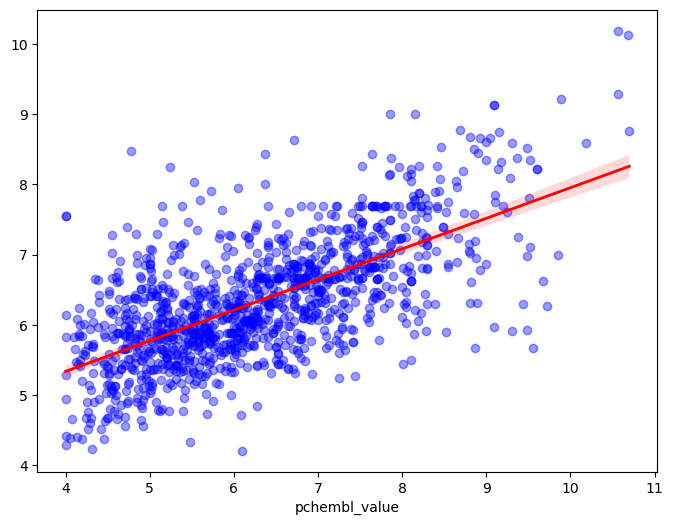

In [30]:
plt.figure(figsize=(8,6))
sns.regplot(
    x=Y_test,
    y=Y_pred,
    scatter_kws={'alpha': 0.4, 'color': 'blue'},
    line_kws={'color': 'red', 'linewidth': 2}
)

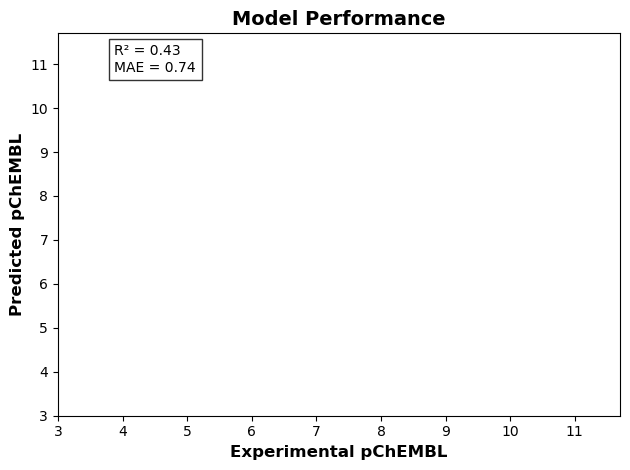

In [31]:
target_name = 'pChEMBL' if 'pchembl_value' in df.columns else 'pIC50'
plt.xlabel(f'Experimental {target_name}', fontsize=12, fontweight='bold')
plt.ylabel(f'Predicted {target_name}', fontsize=12, fontweight='bold')
plt.title('Model Performance', fontsize=14, fontweight='bold')

min_val = min(min(Y_test), min(Y_pred)) - 1
max_val = max(max(Y_test), max(Y_pred)) + 1
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.text(0.1, 0.9,
         f'R² = {r2_score(Y_test, Y_pred):.2f}\nMAE = {mean_absolute_error(Y_test, Y_pred):.2f}',
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()